## Employee Attrition Analysis – Warehouse Fulfilment Centre

This notebook analyses employee attrition using structured employee data and unstructured review text.
The goal is to understand **when employees leave** and **why they leave**, and to identify actionable
retention opportunities.

**Workflow**
1. Setup & Imports  
2. Data Loading  
3. Initial Data Exploration  
4. Feature Engineering  
5. Tenure vs Attrition Analysis  
6. Text & Sentiment Analysis  

In [2]:
# Core libraries
import pandas as pd
import numpy as np
import re 
import nltk
import string

# Visualisation libraries
import matplotlib.pyplot as plt

# Warnings
import warnings
warnings.filterwarnings("ignore")


### Data Loading

The dataset is loaded from the raw data directory. Raw data is preserved, and all transformations
are performed on derived copies to maintain reproducibility.


In [3]:
df = pd.read_csv(r"C:\Users\ADACHUKWU\OneDrive\Desktop\Github Repositories\employee-attrition-analysis\data\raw\Employee_feedback.csv")
df.head(2)

,employee_length,employee_status,employee_type,flags_business_outlook,flags_ceo_approval,flags_recommend_frend,rating_culture_values,rating_diversity_inclusion,rating_overall,rating_work_life,review_summary,employee_location,employee_job_title,advice_to_management,review_pros,review_cons,rating_compensation_benefits,rating_senior_leadership,rating_career_opportunities
0,2 years,regular,Ex employee,Yes,No,Yes,5,5,4,4,"To be fair, promotions feel random; breaks fee...",Wakefield,Warehouse Associate,Priority: sort out rota notice.,"safety is decent is a plus, friendly coworkers",Cons: repetitive tasks,3,4,5
1,7 years,regular,Less than 2 years,No,Yes,Yes,3,4,4,5,"On this site, non-stop work, and benefits are ...",Chelmsford,Forklift Operator,Please sort out rota notice and lower the unre...,"overtime available (when available), canteen i...",too much repetitive tasks,4,4,3


### Exploratory Data Analysis

Initial exploratory checks are performed to understand the structure of the dataset,
the data types of each column, and basic summary statistics.

In [4]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   employee_length               300 non-null    str  
 1   employee_status               300 non-null    str  
 2   employee_type                 300 non-null    str  
 3   flags_business_outlook        300 non-null    str  
 4   flags_ceo_approval            300 non-null    str  
 5   flags_recommend_frend         300 non-null    str  
 6   rating_culture_values         300 non-null    int64
 7   rating_diversity_inclusion    300 non-null    int64
 8   rating_overall                300 non-null    int64
 9   rating_work_life              300 non-null    int64
 10  review_summary                300 non-null    str  
 11  employee_location             300 non-null    str  
 12  employee_job_title            300 non-null    str  
 13  advice_to_management          300 non-null    

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rating_culture_values,300.0,2.746667,1.472997,1.0,1.00,2.0,4.0,5.0
rating_diversity_inclusion,300.0,2.830000,1.474794,1.0,1.00,3.0,4.0,5.0
rating_overall,300.0,2.713333,1.399172,1.0,1.75,2.0,4.0,5.0
rating_work_life,300.0,2.826667,1.454996,1.0,1.75,3.0,4.0,5.0
rating_compensation_benefits,300.0,2.633333,1.432619,1.0,1.00,2.0,4.0,5.0
rating_senior_leadership,300.0,2.863333,1.355525,1.0,2.00,3.0,4.0,5.0
rating_career_opportunities,300.0,2.660000,1.500635,1.0,1.00,2.0,4.0,5.0


In [6]:
df.describe(include='object').T

,count,unique,top,freq
employee_length,300,10,2 years,36
employee_status,300,3,regular,203
employee_type,300,4,Current employee,143
flags_business_outlook,300,2,No,155
flags_ceo_approval,300,2,No,174
flags_recommend_frend,300,2,Yes,150
review_summary,300,300,"To be fair, promotions feel random; breaks fee...",1
employee_location,300,41,York,13
employee_job_title,300,3,Stower,111
advice_to_management,300,133,They should do task rotation to reduce strain.,12


In [7]:
df.shape

(300, 19)

### Data Quality Checks

Basic data quality checks are conducted to ensure the dataset is suitable for analysis.
This includes checks for missing values and duplicate records.

In [8]:
df.isnull().sum()

employee_length                 0
employee_status                 0
employee_type                   0
flags_business_outlook          0
flags_ceo_approval              0
flags_recommend_frend           0
rating_culture_values           0
rating_diversity_inclusion      0
rating_overall                  0
rating_work_life                0
review_summary                  0
employee_location               0
employee_job_title              0
advice_to_management            0
review_pros                     0
review_cons                     0
rating_compensation_benefits    0
rating_senior_leadership        0
rating_career_opportunities     0
dtype: int64

In [9]:
duplicates = int(df.duplicated().sum())
duplicates

0

### Feature Engineering 
**Tenure Bands**

Employee tenure is recorded in mixed formats (months and years).

**To support analysis, tenure is standardised into business-friendly tenure bands**


In [10]:
# Function that categorises length of employment into buckets.
def assign_tenure(tenure):
    number = int(tenure.split()[0])
    
    # Convert tenure to months
    if "month" in tenure:
        months = number
    elif "year" in tenure:
        months = number * 12
    else:
        return "unknown"
    
    # Assign tenure band
    if months < 12:
        return "less than 1 year"
    elif months < 24:
        return "1-2 years"
    elif months < 60:
        return "2-5 years"
    else:
        return "5+ years"

In [11]:
df["tenure"] = df["employee_length"].apply(assign_tenure)

In [12]:
df["tenure"].value_counts()

tenure
2-5 years           97
5+ years            91
less than 1 year    83
1-2 years           29
Name: count, dtype: int64

### Tenure vs Attrition (Analytical Framework)

Employee attrition is rarely driven by a single factor. In operational environments
such as warehouse fulfilment centres, tenure often moderates how employees experience
workload, management practices, and organisational stability.

Rather than analysing tenure and attrition in isolation, this project examines
attrition through a thematic and sentiment-based lens. This approach enables the
identification of early-stage friction points, as well as issues that disproportionately
affect employees who eventually leave the organisation.

Detailed analysis linking themes to tenure and attrition is presented in a later
section, following thematic coding and sentiment analysis.


### NLP Preparation

Create a focused dataset containing only the columns needed for text analysis. This keeps the workflow modular and avoids modifying the raw dataframe.

The following libraries support text preprocessing, keyword extraction, and sentiment analysis.


In [13]:
from nltk.corpus import stopwords
from collections import Counter
from nltk.util import ngrams
from wordcloud import WordCloud
from textblob import TextBlob


# One-time downloads (run once)
nltk.download("stopwords")
nltk.download("punkt")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADACHUKWU\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADACHUKWU\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
# Create dataframe containing relevant columns.
df_sentiment = df[[
    "employee_status", 
    "review_summary", 
    "employee_location", 
    "employee_job_title", 
    "advice_to_management", 
    "review_pros", 
    "review_cons", 
    "tenure"
    ]].copy()

df_sentiment.head(5)

,employee_status,review_summary,employee_location,employee_job_title,advice_to_management,review_pros,review_cons,tenure
0,regular,"To be fair, promotions feel random; breaks fee...",Wakefield,Warehouse Associate,Priority: sort out rota notice.,"safety is decent is a plus, friendly coworkers",Cons: repetitive tasks,2-5 years
1,regular,"On this site, non-stop work, and benefits are ...",Chelmsford,Forklift Operator,Please sort out rota notice and lower the unre...,"overtime available (when available), canteen i...",too much repetitive tasks,5+ years
2,part time,"Tbh, pay is competitive; non-stop work; favour...",Stoke-on-Trent,Forklift Operator,Please improve break planning and support new...,"good friendly coworkers, overtime available is...",Cons: too much managment communication,2-5 years
3,regular,"Tbh, proper PPE, and site feels cold, and work...",Bolton,Stower,They should support new starters more.,"clean site, good shifts can fit students, easy...",long shifts,2-5 years
4,regular,"Honestly, overtime helps; few chances to move ...",Norwich,Stower,Priority: train supervisors better.,"overtime available is a plus, good friendly co...","Cons: short breaks, too much short staffed, po...",5+ years


#### Stopwords Setup

Combine standard English stopwords with domain-specific stopwords to remove generic filler terms that do not add analytical value.


In [15]:
sw = set(stopwords.words("english"))
stop_keywords = {'ok', 'id', 'wouldnt', 'days', 'day', 'tbh', 'site', 'feel', 'much'}
custom_stopwords = sw.union(stop_keywords)

#### Text Cleaning Function

Clean employee feedback text by:
- lowercasing
- removing non-alphabetic characters
- removing stopwords
- handling missing values safely

In [16]:
# Create function to clean dataset.

def clean_text(text):
    if pd.isnull(text):
        return ""
    
    # Convert to string and lowercase
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)

    # Remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in custom_stopwords]

    return " ".join(tokens)

#### Apply Text Cleaning

Apply the cleaning function to selected free-text fields used for keyword and sentiment analysis.

In [17]:
# List the columns to clean.
text_cols = ['review_summary', 'advice_to_management']

for col in text_cols:
    df_sentiment[f'cleaned_{col}'] = df_sentiment[col].apply(clean_text)

In [18]:
df_sentiment.head(5)

,employee_status,review_summary,employee_location,employee_job_title,advice_to_management,review_pros,review_cons,tenure,cleaned_review_summary,cleaned_advice_to_management
0,regular,"To be fair, promotions feel random; breaks fee...",Wakefield,Warehouse Associate,Priority: sort out rota notice.,"safety is decent is a plus, friendly coworkers",Cons: repetitive tasks,2-5 years,fair promotions random breaks short worst best,priority sort rota notice
1,regular,"On this site, non-stop work, and benefits are ...",Chelmsford,Forklift Operator,Please sort out rota notice and lower the unre...,"overtime available (when available), canteen i...",too much repetitive tasks,5+ years,nonstop work benefits weak development limited...,please sort rota notice lower unrealistic targets
2,part time,"Tbh, pay is competitive; non-stop work; favour...",Stoke-on-Trent,Forklift Operator,Please improve break planning and support new...,"good friendly coworkers, overtime available is...",Cons: too much managment communication,2-5 years,pay competitive nonstop work favouritism rotas...,please improve break planning support new star...
3,regular,"Tbh, proper PPE, and site feels cold, and work...",Bolton,Stower,They should support new starters more.,"clean site, good shifts can fit students, easy...",long shifts,2-5 years,proper ppe feels cold workload heavy training ...,support new starters
4,regular,"Honestly, overtime helps; few chances to move ...",Norwich,Stower,Priority: train supervisors better.,"overtime available is a plus, good friendly co...","Cons: short breaks, too much short staffed, po...",5+ years,honestly overtime helps chances move rotas cha...,priority train supervisors better


#### Keyword Frequency (Unigrams)

Tokenise cleaned text and compute the most frequent keywords to identify recurring themes in employee feedback.

In [19]:
# Tokenize Text into Words.

# Join all column into one big string, then split into words.
all_words = ' '.join(df_sentiment['cleaned_review_summary']).split()

# To determine the frequency of Keywords.
word_counts = Counter(all_words)
word_counts.most_common(20)

[('good', 96),
 ('pay', 95),
 ('short', 58),
 ('training', 57),
 ('recommend', 55),
 ('decent', 45),
 ('long', 42),
 ('fair', 37),
 ('worst', 36),
 ('best', 36),
 ('someone', 36),
 ('tough', 36),
 ('people', 36),
 ('shifts', 36),
 ('gonna', 36),
 ('lie', 36),
 ('stint', 33),
 ('one', 33),
 ('shift', 32),
 ('safety', 31)]

#### Visualise Top Keywords

Plot the most common keywords to highlight dominant themes mentioned in reviews.


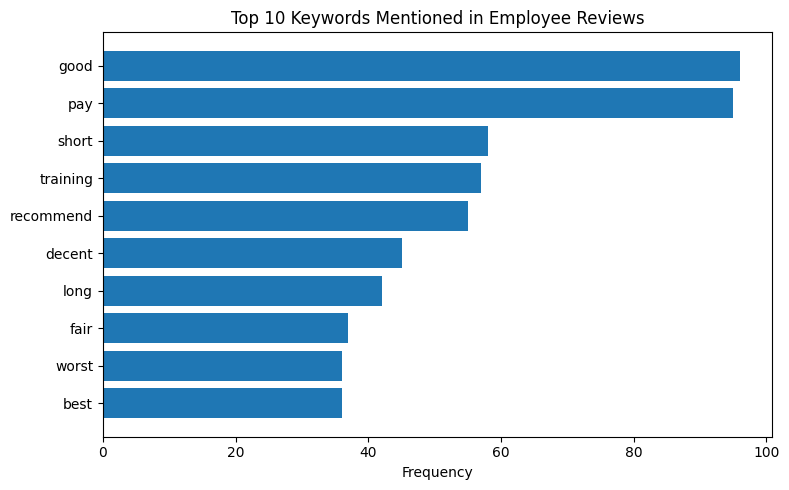

In [20]:
# Visualise keywords using graphs and charts.
top10 = word_counts.most_common(10)
words, counts = zip(*top10)

plt.figure(figsize=(8,5))
plt.barh(words, counts)
plt.xlabel("Frequency")
plt.title("Top 10 Keywords Mentioned in Employee Reviews")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


#### Phrase Analysis (Bigrams & Trigrams)

Unigrams show common topics, but phrases often reveal clearer meaning (e.g., "long shifts", "poor management"). This section extracts common bigrams and trigrams.


In [21]:
bigrams = list(ngrams(all_words, 2))
trigrams = list(ngrams(all_words, 3))

bigram_counts = Counter(bigrams)
trigram_counts = Counter(trigrams)

#### Visualise Common Phrases (Bigrams)

Bigrams highlight common two-word phrases (e.g., "long shifts", "poor management") which often capture meaning better than single keywords.

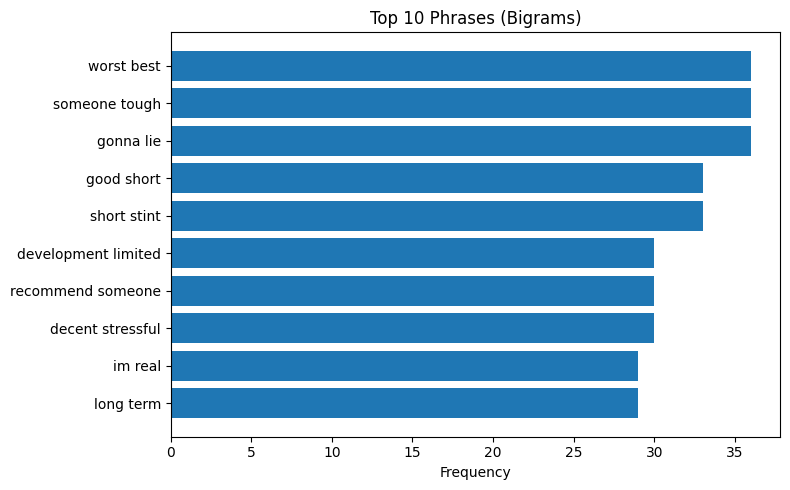

In [23]:
common_bigrams = bigram_counts.most_common(10)

bg_labels = [' '.join(bg) for bg, count in common_bigrams]
bg_counts = [count for bg, count in common_bigrams]

plt.figure(figsize=(8,5))
plt.barh(bg_labels, bg_counts)
plt.xlabel("Frequency")
plt.title("Top 10 Phrases (Bigrams)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [24]:
trigram_counts.most_common(10)

[(('good', 'short', 'stint'), 33),
 (('recommend', 'someone', 'tough'), 30),
 (('could', 'good', 'better'), 28),
 (('need', 'quick', 'money'), 28),
 (('career', 'path', 'unclear'), 25),
 (('toxic', 'vibe', 'sometimes'), 25),
 (('recommend', 'long', 'term'), 25),
 (('stay', 'fixed', 'basics'), 24),
 (('managers', 'dont', 'listen'), 24),
 (('pay', 'doesnt', 'match'), 22)]

#### Visualise Common Phrases (Trigrams)

Trigrams show common three-word phrases, which can reveal more specific recurring complaints and themes.

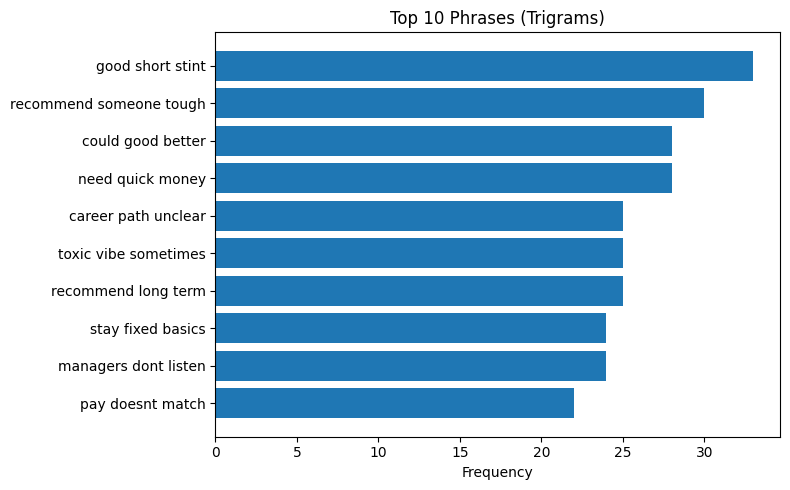

In [56]:
common_trigrams = trigram_counts.most_common(10)
tg_labels = [' '.join(tg) for tg, count in common_trigrams]
tg_counts = [count for tg, count in common_trigrams]

plt.figure(figsize=(8,5))
plt.barh(tg_labels, tg_counts)
plt.xlabel("Frequency")
plt.title("Top 10 Phrases (Trigrams)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Word Cloud

A word cloud provides a quick visual summary of the most prominent terms across employee reviews after preprocessing.

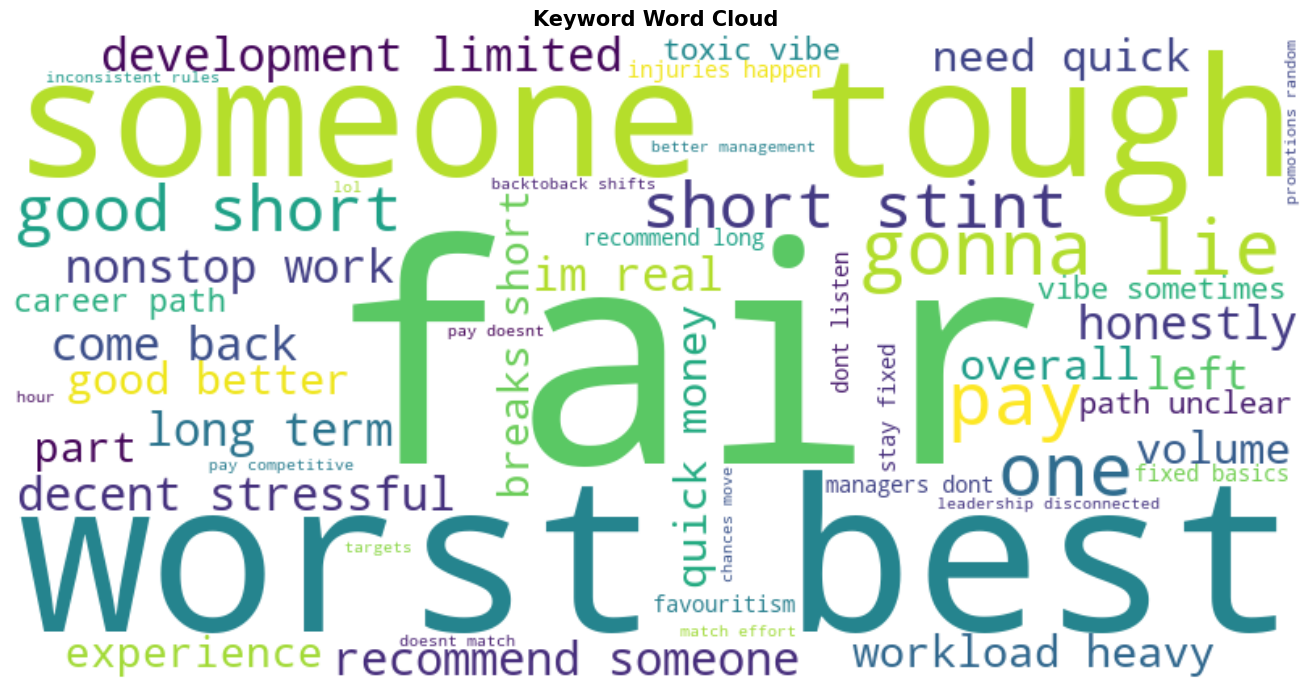

In [26]:
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=50,
    relative_scaling=0.5,
    min_font_size=10
    ).generate(' '.join(all_words))

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Keyword Word Cloud", fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

### Thematic Analysis
- **Topic Modeling**

This section applies topic modeling to employee review text to uncover
underlying themes in employee feedback. An inductive approach is used so
themes emerge directly from the data rather than being predefined.


In [ ]:
# Convert text to TF-IDF matrix.

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

tfidf = TfidfVectorizer(
    max_features=1000,    # Only keep the 1000 most important words
    stop_words='english', # Ignore filler words
    max_df=0.9,           # Ignore words in >90% of reviews
    min_df=5,             # ignore very rare words
    ngram_range=(1, 2)    # include unigrams + bigrams
)

X_tfidf = tfidf.fit_transform(df_sentiment['cleaned_review_summary'])

In [37]:
X_tfidf.shape

(300, 196)

In [38]:
# Apply NMF to extract 6 topics.

n_topics = 6

nmf = NMF(n_components=n_topics, 
          random_state=42, 
          max_iter=300
)

nmf.fit(X_tfidf)

,"n_components n_components: int or {'auto'} or None, default='auto'Number of components. If `None`, all features are kept.If `n_components='auto'`, the number of components is automatically inferredfrom W or H shapes... versionchanged:: 1.4 Added `'auto'` value... versionchanged:: 1.6 Default value changed from `None` to `'auto'`.",6
,"init init: {'random', 'nndsvd', 'nndsvda', 'nndsvdar', 'custom'}, default=NoneMethod used to initialize the procedure.Valid options:- `None`: 'nndsvda' if n_components <= min(n_samples, n_features), otherwise random.- `'random'`: non-negative random matrices, scaled with: `sqrt(X.mean() / n_components)`- `'nndsvd'`: Nonnegative Double Singular Value Decomposition (NNDSVD) initialization (better for sparseness)- `'nndsvda'`: NNDSVD with zeros filled with the average of X (better when sparsity is not desired)- `'nndsvdar'` NNDSVD with zeros filled with small random values (generally faster, less accurate alternative to NNDSVDa for when sparsity is not desired)- `'custom'`: Use custom matrices `W` and `H` which must both be provided... versionchanged:: 1.1 When `init=None` and n_components is less than n_samples and n_features defaults to `nndsvda` instead of `nndsvd`.",None
,"solver solver: {'cd', 'mu'}, default='cd'Numerical solver to use:- 'cd' is a Coordinate Descent solver.- 'mu' is a Multiplicative Update solver... versionadded:: 0.17 Coordinate Descent solver... versionadded:: 0.19 Multiplicative Update solver.",'cd'
,"beta_loss beta_loss: float or {'frobenius', 'kullback-leibler', 'itakura-saito'}, default='frobenius'Beta divergence to be minimized, measuring the distance between Xand the dot product WH. Note that values different from 'frobenius'(or 2) and 'kullback-leibler' (or 1) lead to significantly slowerfits. Note that for beta_loss <= 0 (or 'itakura-saito'), the inputmatrix X cannot contain zeros. Used only in 'mu' solver... versionadded:: 0.19",'frobenius'
,"tol tol: float, default=1e-4Tolerance of the stopping condition.",0.0001
,"max_iter max_iter: int, default=200Maximum number of iterations before timing out.",300
,"random_state random_state: int, RandomState instance or None, default=NoneUsed for initialisation (when ``init`` == 'nndsvdar' or'random'), and in Coordinate Descent. Pass an int for reproducibleresults across multiple function calls.See :term:`Glossary `.",42
,"alpha_W alpha_W: float, default=0.0Constant that multiplies the regularization terms of `W`. Set it to zero(default) to have no regularization on `W`... versionadded:: 1.0",0.0
,"alpha_H alpha_H: float or ""same"", default=""same""Constant that multiplies the regularization terms of `H`. Set it to zero tohave no regularization on `H`. If ""same"" (default), it takes the same value as`alpha_W`... versionadded:: 1.0",'same'
,"l1_ratio l1_ratio: float, default=0.0The regularization mixing parameter, with 0 <= l1_ratio <= 1.For l1_ratio = 0 the penalty is an elementwise L2 penalty(aka Frobenius Norm).For l1_ratio = 1 it is an elementwise L1 penalty.For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2... versionadded:: 0.17 Regularization parameter *l1_ratio* used in the Coordinate Descent solver.",0.0
,"verbose verbose: int, default=0Whether to be verbose.",0


In [40]:
# Get the vocabulary from TF-IDF
feature_names = tfidf.get_feature_names_out()

# Function to display top words for each topic
def display_topics(model, feature_names, n_top_words=10):
    """Display the top words for each topic discovered by the model."""
    
    print("="*70)
    print(f"DISCOVERED TOPICS (Top {n_top_words} keywords per topic):")
    print("="*70)
    
    for topic_idx, topic in enumerate(model.components_):
        # Get the top N words for this topic
        top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"\nTopic {topic_idx + 1}: {', '.join(top_features)}")

# Display the topics
display_topics(nmf, feature_names, n_top_words=20)

DISCOVERED TOPICS (Top 20 keywords per topic):

Topic 1: good, short, short stint, stint, good short, better, good better, managers dont, dont listen, managers, listen, dont, better management, management, shifts, experience, work, nonstop work, nonstop, slow

Topic 2: need, need quick, quick, quick money, money, decent, worst, best, worst best, night, drains, exists, roles, training roles, roles exists, shift drains, night shift, decent stressful, stressful, pay decent

Topic 3: doesnt match, match, match effort, pay doesnt, effort, doesnt, pay, tough, recommend tough, honestly, volume, people, worst best, worst, best, injuries, happen, injuries happen, people quit, quit lot

Topic 4: recommend, long, long term, term, recommend long, recommend tough, tough, random, promotions random, promotions, gonna lie, lie, gonna, training, leadership disconnected, leadership, disconnected, shifts, favouritism, experience

Topic 5: unclear, career, path unclear, path, career path, late, change lat

### Interpreting Discovered Topics

The topic model surfaces several recurring and overlapping patterns in employee feedback.
Based on the most representative keywords, the discovered topics can be interpreted as:

- **Short-Term Employment & Management Responsiveness**  
  Reviews indicating that the role is tolerable in the short term, but managers are perceived as not listening to employee concerns.

- **Financial Necessity vs Physical and Mental Exhaustion**  
  Feedback suggesting employees remain in the role primarily for quick income, while experiencing fatigue—particularly from night shifts.

- **Effort–Pay Imbalance**  
  Strong perceptions that workload intensity and output expectations are not matched by compensation.

- **Unclear Progression and Promotion Fairness**  
  Concerns around long-term prospects, with promotions viewed as inconsistent or random rather than merit-based.

- **Operational Instability and Scheduling Changes**  
  Frequent rota changes, inconsistent rules, and unclear career paths contributing to uncertainty and dissatisfaction.

- **Competitive Pay with Demanding Shift Patterns**  
  Mixed feedback indicating acceptable pay levels, but sustained by physically demanding back-to-back shifts.

These themes provide a structured foundation for deeper qualitative analysis and
can be used to examine how specific issues relate to tenure, sentiment, and employee attrition.


### Thematic Coding & Theme Assignment

This section translates the discovered topics into a structured thematic framework.
A rule-based coding approach is used to consistently tag employee reviews with
interpretable business themes, enabling quantitative analysis of qualitative data.


### Final Theme Framework

Based on topic modeling results, the following themes are defined:

1. Management Responsiveness
2. Burnout and Demanding Shifts
3. Pay Imbalance
4. Progression & Promotion Unfairness
5. Operational Instability & Scheduling

In [ ]:
theme_codebook = {
    
    "Management Responsiveness": [
        "managers dont listen", "dont listen", "leadership disconnected", 
        "better management", "management ignores", "management doesnt care"
    ],
    
    "Burnout & Demanding Shifts": [
        "shift drains", "drains energy", "backtoback shifts", "nonstop work",
        "injuries happen", "stressful shifts", "exhausting shifts", "burnout",
        "workload", "heavy training"
    ],
    
    "Pay Imbalance": [
        "pay doesnt match", "pay doesnt reflect", "underpaid", 
        "low pay", "poor compensation", "salary low"
    ],
    
    "Progression & Promotion Unfairness": [
        "promotions random", "no promotion", "favouritism", 
        "unfair promotions", "no career growth", "stuck same role"
    ],
    
    "Operational Instability & Scheduling": [
        "rotas change", "change late", "inconsistent rules", 
        "last minute changes", "schedule chaos", "poor planning"
    ],
}


In [42]:
def assign_themes(text, codebook):
    if not text:
        return []

    text = text.lower()
    matched_themes = []

    for theme, keywords in codebook.items():
        for kw in keywords:
            pattern = r"\b" + re.escape(kw).replace(r"\ ", r"\s+") + r"\b"
            if re.search(pattern, text):
                matched_themes.append(theme)
                break

    return matched_themes


In [43]:
# Apply thematic coding to reviews (Code)

df_sentiment['matched_themes'] = df_sentiment['cleaned_review_summary'].apply(
    lambda x: assign_themes(x, theme_codebook)
)

In [45]:
df_sentiment[["cleaned_review_summary", "matched_themes"]].head(5)

,cleaned_review_summary,matched_themes
0,fair promotions random breaks short worst best,[Progression & Promotion Unfairness]
1,nonstop work benefits weak development limited...,[Burnout & Demanding Shifts]
2,pay competitive nonstop work favouritism rotas...,"[Burnout & Demanding Shifts, Progression & Pro..."
3,proper ppe feels cold workload heavy training ...,[]
4,honestly overtime helps chances move rotas cha...,[Operational Instability & Scheduling]


In [46]:
all_themes = [theme for themes_list in df_sentiment['matched_themes'] for theme in themes_list]
theme_counts = Counter(all_themes)

print("\n" + "="*70)
print("Theme Distribution:")
print("="*70)
for theme, count in theme_counts.most_common():
    print(f"{theme}: {count} reviews")



Theme Distribution:
Burnout & Demanding Shifts: 84 reviews
Management Responsiveness: 68 reviews
Progression & Promotion Unfairness: 45 reviews
Operational Instability & Scheduling: 41 reviews
Pay Imbalance: 22 reviews


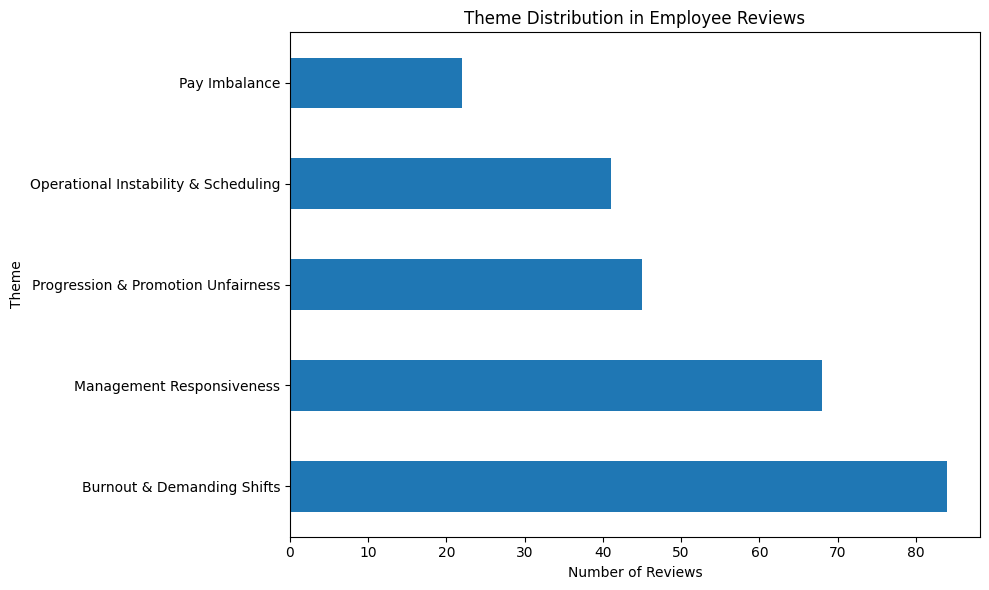

In [47]:
theme_df = pd.DataFrame(theme_counts.most_common(), columns=['Theme', 'Count'])
theme_df.plot(
    x='Theme', 
    y='Count', 
    kind='barh', 
    title='Theme Distribution in Employee Reviews',
    xlabel='Number of Reviews',
    legend=False,
    figsize=(10, 6)
)
plt.tight_layout()
plt.show()

### Sentiment Analysis

Sentiment analysis is used to quantify the emotional tone of employee feedback.
Using TextBlob, each review is assigned a polarity score ranging from:
- **-1** (very negative)
- **0** (neutral)
- **+1** (very positive)

This allows qualitative feedback to be analysed quantitatively and compared across groups.


In [27]:
# Score each employee review in terms of facts, opinion, and sentiment.

df_sentiment['sentiment_polarity'] = df_sentiment['cleaned_review_summary'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_sentiment['sentiment_subjectivity'] = df_sentiment['cleaned_review_summary'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [28]:
df_sentiment.head(2)

,employee_status,review_summary,employee_location,employee_job_title,advice_to_management,review_pros,review_cons,tenure,cleaned_review_summary,cleaned_advice_to_management,sentiment_polarity,sentiment_subjectivity
0,regular,"To be fair, promotions feel random; breaks fee...",Wakefield,Warehouse Associate,Priority: sort out rota notice.,"safety is decent is a plus, friendly coworkers",Cons: repetitive tasks,2-5 years,fair promotions random breaks short worst best,priority sort rota notice,0.040000,0.600000
1,regular,"On this site, non-stop work, and benefits are ...",Chelmsford,Forklift Operator,Please sort out rota notice and lower the unre...,"overtime available (when available), canteen i...",too much repetitive tasks,5+ years,nonstop work benefits weak development limited...,please sort rota notice lower unrealistic targets,-0.283829,0.500298


In [29]:
# Create Sentiment Labels.
def label_sentiment(score):
  if score > 0.1:
    return 'positive'
  elif score < -0.1:
    return 'negative'
  else:
    return 'neutral'
  
# Apply to reviews.

df_sentiment['sentiment_label'] = df_sentiment['sentiment_polarity'].apply(label_sentiment)

In [30]:
df_sentiment.head(2)

,employee_status,review_summary,employee_location,employee_job_title,advice_to_management,review_pros,review_cons,tenure,cleaned_review_summary,cleaned_advice_to_management,sentiment_polarity,sentiment_subjectivity,sentiment_label
0,regular,"To be fair, promotions feel random; breaks fee...",Wakefield,Warehouse Associate,Priority: sort out rota notice.,"safety is decent is a plus, friendly coworkers",Cons: repetitive tasks,2-5 years,fair promotions random breaks short worst best,priority sort rota notice,0.040000,0.600000,neutral
1,regular,"On this site, non-stop work, and benefits are ...",Chelmsford,Forklift Operator,Please sort out rota notice and lower the unre...,"overtime available (when available), canteen i...",too much repetitive tasks,5+ years,nonstop work benefits weak development limited...,please sort rota notice lower unrealistic targets,-0.283829,0.500298,negative


### Sentiment Distribution

The distribution of sentiment scores provides an overview of overall employee tone
and helps identify whether feedback skews negative, neutral, or positive.


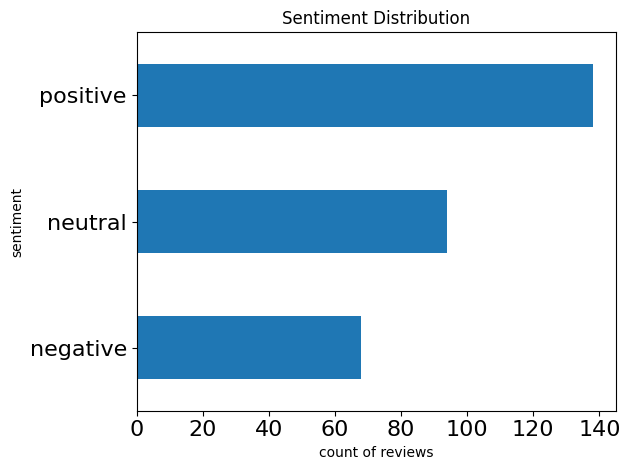

In [34]:
# Visualising the sentiment distribution.

df_sentiment['sentiment_label'].value_counts().sort_values(ascending=True).plot(
    kind='barh', title='Sentiment Distribution', fontsize=16
)
plt.xlabel("count of reviews")
plt.ylabel('sentiment')
plt.tight_layout()
plt.show()

In [51]:
df_exploded = df_sentiment.explode("matched_themes")


In [52]:
top_themes = (
    df_exploded["matched_themes"]
    .value_counts()
    .head(5)
    .index
)


In [53]:
df2_filtered = df_exploded[df_exploded["matched_themes"].isin(top_themes)]


In [54]:
sentiment_counts = (
    df2_filtered
    .groupby(["matched_themes", "sentiment_label"])
    .size()
    .unstack(fill_value=0)
)


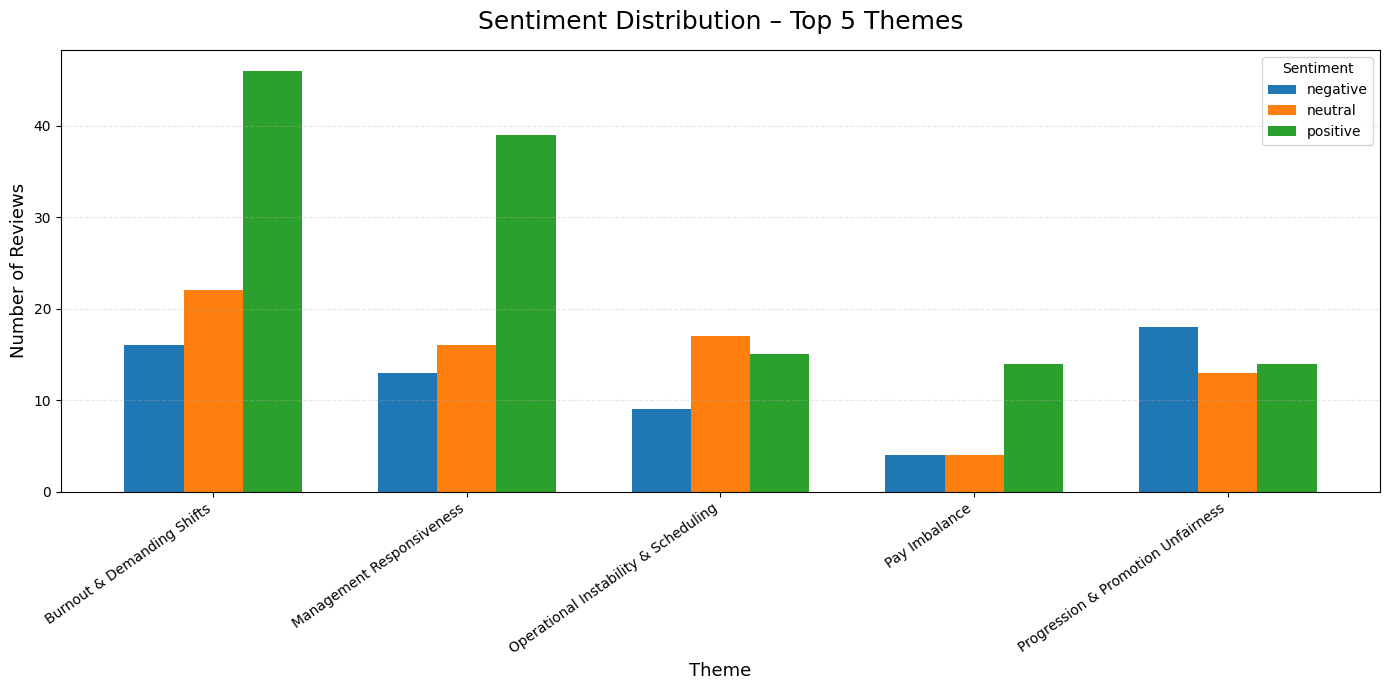

In [55]:
sentiment_counts.plot(
    kind="bar",
    figsize=(14, 7),
    width=0.7
)

plt.title("Sentiment Distribution – Top 5 Themes", fontsize=18, pad=15)
plt.xlabel("Theme", fontsize=13)
plt.ylabel("Number of Reviews", fontsize=13)
plt.legend(title="Sentiment")
plt.xticks(rotation=35, ha="right")
plt.grid(axis="y", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()


### Employee Segmentation Analysis


In [75]:
# Create a combined segment column using employee status and job title.


df_sentiment['segment'] = (
     df_sentiment['employee_status']  + ' ' + 
    df_sentiment['employee_job_title']
)


In [76]:
df_sentiment[["segment"]].value_counts()

segment                      
regular Stower                   74
regular Forklift Operator        66
regular Warehouse Associate      63
part time Stower                 26
part time Warehouse Associate    23
part time Forklift Operator      21
contract Stower                  11
contract Warehouse Associate     10
contract Forklift Operator        6
Name: count, dtype: int64

In [90]:

df_exploded = df_sentiment.explode("matched_themes")

segment_theme_counts = (
    df_exploded
        .groupby(["segment", "matched_themes"])
        .size()
        .unstack(fill_value=0)
)

# Total employee count per segment
segment_total_counts = df_sentiment["segment"].value_counts()
segment_theme_counts["segment_size"] = segment_total_counts


# Display the table
# print("="*100)
# print("THEME FREQUENCY BY SEGMENT (Total Counts)")
# print("="*100)
# print(segment_theme_counts)


segment_theme_counts

matched_themes,Burnout & Demanding Shifts,Management Responsiveness,Operational Instability & Scheduling,Pay Imbalance,Progression & Promotion Unfairness,segment_size
segment,,,,,,
contract Forklift Operator,2,1,0,0,0,6
contract Stower,5,0,1,0,3,11
contract Warehouse Associate,0,4,0,0,1,10
part time Forklift Operator,6,3,5,1,3,21
part time Stower,6,4,4,2,4,26
part time Warehouse Associate,7,4,5,3,1,23
regular Forklift Operator,20,19,8,5,13,66
regular Stower,17,13,9,5,14,74
regular Warehouse Associate,21,20,9,6,6,63


In [83]:
segment_theme_counts.to_csv('theme_frequency_by_segment.csv')